In [2]:
import pandas as pd
import os
import glob
import random
import numpy as np
import warnings
warnings.filterwarnings('ignore')

from scipy.stats import ttest_rel
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

## Data Preparation

In [3]:
path = r'/Users/spencersu/Desktop/JCPS Efficacy Report/Datasets'

In [4]:
all_files = glob.glob(path + "/JeffCo 8th Grade for Scoring*.csv")

li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

In [5]:
for filename in all_files:
    print(filename)

/Users/spencersu/Desktop/JCPS Efficacy Report/Datasets/JeffCo 8th Grade for Scoring - 3rd grade for scoring.csv
/Users/spencersu/Desktop/JCPS Efficacy Report/Datasets/JeffCo 8th Grade for Scoring - 8th grade for scoring.csv
/Users/spencersu/Desktop/JCPS Efficacy Report/Datasets/JeffCo 8th Grade for Scoring - 4th grade for scoring.csv
/Users/spencersu/Desktop/JCPS Efficacy Report/Datasets/JeffCo 8th Grade for Scoring - 10th grade for scoring.csv
/Users/spencersu/Desktop/JCPS Efficacy Report/Datasets/JeffCo 8th Grade for Scoring - 12th grade for scoring.csv
/Users/spencersu/Desktop/JCPS Efficacy Report/Datasets/JeffCo 8th Grade for Scoring - 9th grade for scoring.csv
/Users/spencersu/Desktop/JCPS Efficacy Report/Datasets/JeffCo 8th Grade for Scoring - 6th grade for scoring.csv
/Users/spencersu/Desktop/JCPS Efficacy Report/Datasets/JeffCo 8th Grade for Scoring - 7th grade.csv
/Users/spencersu/Desktop/JCPS Efficacy Report/Datasets/JeffCo 8th Grade for Scoring - 11th grade for scoring.csv


In [6]:
# grade 8 file has a different first row than the other files
li[1].columns = li[1].iloc[0]

li[1] = li[1].iloc[1:,:]

In [7]:
# grade 4 already has a grade_level column
li[2].columns = li[0].columns

In [8]:
# change all subtype column to a name "subtype"
for num in range(0,9):
    li[num].rename(columns={li[num].columns[2]: "subtype" }, inplace = True)

In [9]:
def unify_col(grade_level, number):
    li[number].insert(7, 'student_grade_level', grade_level)
    li[number].columns = li[0].columns

In [10]:
unify_col(8,1)
unify_col(10,3)
unify_col(12,4)
unify_col(9,5)
unify_col(6,6)
unify_col(7,7)
unify_col(11,8)

In [11]:
df = pd.concat(li, axis=0, ignore_index=True)

In [12]:
# arrange format in the dataset 

df = df[df.Conventions != "4(Should not be in all caps though)"]

## arranage data types
df['subtype'] = pd.to_numeric(df['subtype'])
df.iloc[:,10] = pd.to_numeric(df.iloc[:,10])
df.iloc[:,11] = pd.to_numeric(df.iloc[:,11])
df.iloc[:,12] = pd.to_numeric(df.iloc[:,12])
df.iloc[:,13] = pd.to_numeric(df.iloc[:,13])
df.iloc[:,14] = pd.to_numeric(df.iloc[:,14])
df.iloc[:,15] = pd.to_numeric(df.iloc[:,15])
df.iloc[:,16] = pd.to_numeric(df.iloc[:,16])


## drop subtype = 5
df = df[df.subtype != 5]

## drop grade level 3 and 4
df = df[df.student_grade_level != (3,4)]

## drop na for the framework columns 
c = df.iloc[:, 10:16].columns 
df = df.dropna(subset=c, how='all')

In [13]:
df

,id,last_updated,subtype,school_name,primary_teacher_name,class_code,student_name,student_grade_level,gradelink,student_writing,ClaimCounter,Reasons,Evidence,Reasoning,Organization,Audience,Conventions
1,15721060,5/19/21,6,Engelhard Elementary,JUSTIN MEHLING,PDGXBA,Domnyck Scholl,3,https://learn.thinkcerca.com/teacher/lesson_as...,"""No they should not be payed to do school work...",3.0,2.0,1.0,1.0,1.0,2.0,3.0
3,15669336,5/11/21,6,Trunnell Elementary,Rosa Arnold,FBCLQA,Ezekiel Batista Perera,3,https://learn.thinkcerca.com/teacher/lesson_as...,"""students soild not be paid todo homework beca...",3.0,2.0,1.0,1.0,1.0,2.0,3.0
5,15703917,5/11/21,6,Trunnell Elementary,Rosa Arnold,FBCLQA,Greidys Godinez Vazquez,3,https://learn.thinkcerca.com/teacher/lesson_as...,"""i say no becaues they mihght spend it all in ...",3.0,2.0,1.0,1.0,1.0,1.0,4.0
7,15669330,5/17/21,6,Trunnell Elementary,Rosa Arnold,FBCLQA,Haley Church,3,https://learn.thinkcerca.com/teacher/lesson_as...,"""yes they should get paid for homework an othe...",3.0,2.0,1.0,1.0,1.0,2.0,4.0
9,15721059,5/21/21,6,Engelhard Elementary,JUSTIN MEHLING,PDGXBA,James Thomas,3,NaN,"""yes we should be payd. becus adults only get ...",3.0,2.0,1.0,1.0,1.0,2.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2034,14184022,9/21/20,4,Crosby Middle,ANASTASIA BINGHAM,LSASGQ,Collins Taylor,7,NaN,"""air conditioning is good for humanity because...",2.0,1.0,1.0,1.0,1.0,1.0,1.0
2035,15706014,5/27/21,6,Crosby Middle,ANASTASIA BINGHAM,LSASGQ,Collins Taylor,7,NaN,"""I do not belie that schools should eliminate ...",2.0,3.0,1.0,2.0,3.0,3.0,2.0
2036,14183498,9/21/20,4,Crosby Middle,ANASTASIA BINGHAM,N5UELW,David Joynt,7,NaN,"""no because the cost is not worth it """"",2.0,1.0,1.0,1.0,1.0,1.0,1.0
2037,15706070,5/25/21,6,Crosby Middle,ANASTASIA BINGHAM,N5UELW,David Joynt,7,NaN,""" I think summer break should stay. This is be...",2.0,2.0,1.0,2.0,3.0,3.0,3.0


In [15]:
df.groupby('student_grade_level')['id'].count()

student_grade_level
3      12
4      15
6     251
7      38
8     598
9     112
10     16
Name: id, dtype: int64

## Check the pre- and post- difference

### a. paired sample t-test

In [13]:
# random sample in each subtype group so that we can get the same number of pre- and post- data
# random.seed(50)
# df_paired = df.groupby('subtype').apply(lambda x: x.sample(120)).reset_index(drop=True)

In [14]:
# df_pre = df_paired.loc[df_paired['subtype'] == 4]
# df_post = df_paired.loc[df_paired['subtype'] == 6]

In [15]:
pre = df.loc[df['subtype'] == 4]
post = df.loc[df['subtype'] == 6]

pre = pre.iloc[:,[0,2,3,4,5,6,7,10,11,12,13,14,15,16]]
post = post.iloc[:,[6,10,11,12,13,14,15,16]]

df_new = pd.merge(pre, post, on='student_name', how='inner')

In [16]:
df_new.describe()

,subtype,student_grade_level,ClaimCounter_x,Reasons_x,Evidence_x,Reasoning_x,Organization_x,Audience_x,Conventions_x,ClaimCounter_y,Reasons_y,Evidence_y,Reasoning_y,Organization_y,Audience_y,Conventions_y
count,498.0,498.000000,498.000000,498.000000,498.000000,497.000000,498.000000,498.000000,496.000000,498.000000,498.000000,498.000000,498.000000,498.000000,498.000000,498.000000
mean,4.0,7.592369,2.453815,2.666667,2.114458,2.340040,2.116466,3.076305,3.497984,2.881526,2.983936,2.347390,2.867470,2.686747,3.457831,3.759036
std,0.0,1.021156,0.936019,1.058326,0.904356,1.126597,0.948625,1.206205,1.065528,1.032675,1.008886,1.007918,1.155211,1.073864,1.129105,0.965277
min,4.0,6.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,4.0,6.000000,2.000000,2.000000,1.000000,1.000000,1.000000,2.000000,3.000000,2.000000,2.000000,2.000000,2.000000,2.000000,3.000000,3.000000
50%,4.0,8.000000,2.000000,3.000000,2.000000,2.000000,2.000000,3.000000,4.000000,3.000000,3.000000,2.000000,3.000000,3.000000,4.000000,4.000000
75%,4.0,8.000000,3.000000,3.000000,3.000000,3.000000,3.000000,4.000000,4.000000,4.000000,4.000000,3.000000,4.000000,3.000000,4.000000,4.000000
max,4.0,10.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


In [17]:
# sns.regplot(df['subtype'],df['Evidence'],
#            scatter_kws={"color": "black"}, line_kws={"color": "red"}, ci=None)
# plt.xlim(3,7)
# plt.xlabel('Number of Assignments')
# plt.ylabel('Evidence')
# plt.show()

In [18]:
# counter claim
ttest_rel(df_new['ClaimCounter_x'], df_new['ClaimCounter_y'])

Ttest_relResult(statistic=-9.090618475235614, pvalue=2.3511392673158553e-18)

In [19]:
# reasons 
ttest_rel(df_new['Reasons_x'], df_new['Reasons_y'])

Ttest_relResult(statistic=-6.743436322887942, pvalue=4.3074649773546055e-11)

In [20]:
# evidence 
ttest_rel(df_new['Evidence_x'], df_new['Evidence_y'])

Ttest_relResult(statistic=-5.038507612397452, pvalue=6.579018266586992e-07)

In [21]:
# reasoning
ttest_rel(df_new['Reasoning_x'], df_new['Reasoning_y'])

Ttest_relResult(statistic=nan, pvalue=nan)

In [22]:
# organization
ttest_rel(df_new['Organization_x'], df_new['Organization_y'])

Ttest_relResult(statistic=-12.816399202197172, pvalue=1.0849560073164187e-32)

In [23]:
# audience
ttest_rel(df_new['Audience_x'], df_new['Audience_y'])

Ttest_relResult(statistic=-8.509738196429968, pvalue=2.06975305078973e-16)

In [24]:
# conventions
ttest_rel(df_new['Conventions_x'], df_new['Conventions_y'])

Ttest_relResult(statistic=nan, pvalue=nan)

In [25]:
## add one or plot showing the standard deviation of the two samples, s

### b. regression

In [26]:
num_asgmt = pd.read_csv(os.path.join(path, 'Student Assignments 2020-2021 School Year.csv'))

In [27]:
num_asgmt = num_asgmt.rename(columns = {'1. Usage and Performance Information Student Id [Sensitive]':'id', 
                                        '1. Usage and Performance Information Full Name [Sensitive]':'student_name', 
                                        'Count of Student Assignment Id':'num_assignments_submitted'}, inplace = False)

In [28]:
num_asgmt

,id,student_name,num_assignments_submitted
0,4498,Viviana Acosta,1
1,4903,Daisy Garcia,3
2,12769,Ariana Wafer,2
3,23006,Hannah Arocho,1
4,27184,Isamar Prado,1
...,...,...,...
87708,1220055,Nicolas Test1,2
87709,1220056,Annalis Test1,1
87710,1220057,Owen Test3,1
87711,1220631,Luis Aguilar,2


In [29]:
df_reg = pd.merge(df_new, num_asgmt, on='student_name', how = 'inner')

In [30]:
df_reg

,id_x,subtype,school_name,primary_teacher_name,class_code,student_name,student_grade_level,ClaimCounter_x,Reasons_x,Evidence_x,...,Conventions_x,ClaimCounter_y,Reasons_y,Evidence_y,Reasoning_y,Organization_y,Audience_y,Conventions_y,id_y,num_assignments_submitted
0,14196305,4,Stuart Academy,Christian Kampschaefer,2SM7CQ,Aaron Anderson,8,2.0,1.0,1.0,...,2.0,1.0,2.0,1.0,1.0,1.0,1.0,2.0,1046947,9
1,14476405,4,Crosby Middle,JACOB MAYER,KAY9NA,Aaron Reynolds,8,1.0,2.0,2.0,...,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1042106,3
2,14397398,4,Kammerer Middle,Kimberly Crone,8JTX2A,Aaron Welch,8,3.0,3.0,3.0,...,3.0,4.0,4.0,3.0,4.0,4.0,5.0,4.0,1104305,3
3,14185857,4,Stuart Academy,Dalton Holt,LJ6A7W,Abdalla Hussein,8,1.0,1.0,1.0,...,1.0,2.0,3.0,3.0,2.0,2.0,2.0,2.0,1032739,2
4,14568914,4,Crosby Middle,Brenda Gunnell,MHC2YQ,Abigail Grigsby,8,4.0,4.0,4.0,...,5.0,1.0,1.0,1.0,1.0,1.0,4.0,4.0,1023004,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
504,14183910,4,Crosby Middle,ANASTASIA BINGHAM,E6XG4A,Charles Rafferty,7,1.0,1.0,1.0,...,1.0,2.0,2.0,1.0,1.0,2.0,1.0,2.0,1020879,4
505,14183396,4,Crosby Middle,ANASTASIA BINGHAM,NLLUPG,Cirene Gomez Villegas,7,2.0,1.0,2.0,...,2.0,4.0,3.0,1.0,3.0,3.0,3.0,3.0,1021514,4
506,14183492,4,Crosby Middle,ANASTASIA BINGHAM,N5UELW,Clark Gougeon Ball,7,2.0,1.0,1.0,...,2.0,3.0,2.0,1.0,3.0,2.0,3.0,2.0,1046430,5
507,14184022,4,Crosby Middle,ANASTASIA BINGHAM,LSASGQ,Collins Taylor,7,2.0,1.0,1.0,...,1.0,2.0,3.0,1.0,2.0,3.0,3.0,2.0,1048239,3


In [31]:
df_reg['ClaimCounter_diff'] = df_reg['ClaimCounter_y'] - df_reg['ClaimCounter_x']
df_reg['Reasons_diff'] = df_reg['Reasons_y'] - df_reg['Reasons_x']
df_reg['Evidence_diff'] = df_reg['Evidence_y'] - df_reg['Evidence_x']
df_reg['Reasoning_diff'] = df_reg['Reasoning_y'] - df_reg['Reasoning_x']
df_reg['Organization_diff'] = df_reg['Organization_y'] - df_reg['Organization_x']
df_reg['Audience_diff'] = df_reg['Audience_y'] - df_reg['Audience_x']
df_reg['Conventions_diff'] = df_reg['Conventions_y'] - df_reg['Conventions_x']

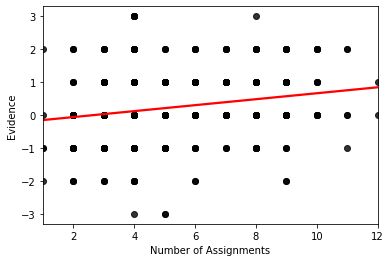

In [32]:
sns.regplot(df_reg['num_assignments_submitted'],df_reg['Evidence_diff'],
           scatter_kws={"color": "black"}, line_kws={"color": "red"}, ci=None)
plt.xlabel('Number of Assignments')
plt.ylabel('Evidence')
plt.show()

In [34]:
# X = df_reg['num_assignments_submitted']
# y = df_reg['Conventions_dif']

# # add a constant
# X = sm.add_constant(X)

# model = sm.OLS(y, X).fit()
# predictions = model.predict(X)

# model.summary()

In [35]:
# mean_squared_error(y, predictions)

In [134]:
# conventions, claimcounter, reasons, reasoning, audience, organization, evidence are all significant
import statsmodels.formula.api as smf

results = smf.ols('ClaimCounter_diff ~ num_assignments_submitted + C(student_grade_level)', data=df_reg).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:      ClaimCounter_diff   R-squared:                       0.067
Model:                            OLS   Adj. R-squared:                  0.058
Method:                 Least Squares   F-statistic:                     7.203
Date:                Fri, 19 Nov 2021   Prob (F-statistic):           1.58e-06
Time:                        12:58:57   Log-Likelihood:                -726.56
No. Observations:                 509   AIC:                             1465.
Df Residuals:                     503   BIC:                             1491.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

In [37]:
# train, test = train_test_split(df_reg, test_size=0.2, random_state=25)

# print(f"No. of training examples: {train.shape[0]}")
# print(f"No. of testing examples: {test.shape[0]}")

In [38]:
# train_X = train['num_assignments_submitted']
# train_y = train['Conventions_dif']

# # add a constant
# train_X = sm.add_constant(train_X)

# model = sm.OLS(train_y, train_X).fit()

# model.summary()

In [39]:
# Alpha (regularization strength) of LASSO regression
lasso_eps = 0.0001
lasso_nalpha=20
lasso_iter=5000
# Min and max degree of polynomials features to consider
degree_min = 1
degree_max = 8

# grade and num_assignments
X = df_reg.iloc[:, [6,24]]

# Test/train split
X_train, X_test, y_train, y_test = train_test_split(X,df_reg['ClaimCounter_diff'],
                                                    test_size=0.2)
# X_train= X_train.values.reshape(-1, 1)
# y_train= y_train.values.reshape(-1, 1)
# X_test = X_test.values.reshape(-1, 1)

# Make a pipeline model with polynomial transformation and LASSO regression with cross-validation, run it for increasing degree of polynomial (complexity of the model)
for degree in range(degree_min,degree_max+1):
    model = make_pipeline(PolynomialFeatures(degree, interaction_only=False), 
                          LassoCV(eps=lasso_eps,n_alphas=lasso_nalpha,max_iter=lasso_iter,normalize=True,cv=5))
    model.fit(X_train,y_train)
    test_pred = np.array(model.predict(X_test))
    RMSE=np.sqrt(np.sum(np.square(test_pred-y_test)))
    test_score = model.score(X_test,y_test)

In [40]:
model = make_pipeline(PolynomialFeatures(1, interaction_only=False), 
                      LassoCV(eps=lasso_eps,n_alphas=lasso_nalpha,max_iter=lasso_iter,normalize=True,cv=5))
model.fit(X_train,y_train)
test_pred = np.array(model.predict(X_test))
print(np.sqrt(np.sum(np.square(test_pred-y_test))))
print(model.score(X_test,y_test))

9.299100640334641
0.02311730896606945


In [41]:
# highest test score is when degree = 1, which is 0.25
test_score

0.057943750039368025

In [42]:
df_reg

,id_x,subtype,school_name,primary_teacher_name,class_code,student_name,student_grade_level,ClaimCounter_x,Reasons_x,Evidence_x,...,Conventions_y,id_y,num_assignments_submitted,ClaimCounter_diff,Reasons_diff,Evidence_diff,Reasoning_diff,Organization_diff,Audience_diff,Conventions_diff
0,14196305,4,Stuart Academy,Christian Kampschaefer,2SM7CQ,Aaron Anderson,8,2.0,1.0,1.0,...,2.0,1046947,9,-1.0,1.0,0.0,0.0,0.0,-1.0,0.0
1,14476405,4,Crosby Middle,JACOB MAYER,KAY9NA,Aaron Reynolds,8,1.0,2.0,2.0,...,1.0,1042106,3,0.0,-1.0,-1.0,0.0,0.0,0.0,-1.0
2,14397398,4,Kammerer Middle,Kimberly Crone,8JTX2A,Aaron Welch,8,3.0,3.0,3.0,...,4.0,1104305,3,1.0,1.0,0.0,1.0,2.0,2.0,1.0
3,14185857,4,Stuart Academy,Dalton Holt,LJ6A7W,Abdalla Hussein,8,1.0,1.0,1.0,...,2.0,1032739,2,1.0,2.0,2.0,1.0,1.0,1.0,1.0
4,14568914,4,Crosby Middle,Brenda Gunnell,MHC2YQ,Abigail Grigsby,8,4.0,4.0,4.0,...,4.0,1023004,4,-3.0,-3.0,-3.0,-1.0,-3.0,-1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
504,14183910,4,Crosby Middle,ANASTASIA BINGHAM,E6XG4A,Charles Rafferty,7,1.0,1.0,1.0,...,2.0,1020879,4,1.0,1.0,0.0,0.0,1.0,0.0,1.0
505,14183396,4,Crosby Middle,ANASTASIA BINGHAM,NLLUPG,Cirene Gomez Villegas,7,2.0,1.0,2.0,...,3.0,1021514,4,2.0,2.0,-1.0,2.0,2.0,2.0,1.0
506,14183492,4,Crosby Middle,ANASTASIA BINGHAM,N5UELW,Clark Gougeon Ball,7,2.0,1.0,1.0,...,2.0,1046430,5,1.0,1.0,0.0,2.0,1.0,2.0,0.0
507,14184022,4,Crosby Middle,ANASTASIA BINGHAM,LSASGQ,Collins Taylor,7,2.0,1.0,1.0,...,2.0,1048239,3,0.0,2.0,0.0,1.0,2.0,2.0,1.0


In [106]:
X_rf = pd.get_dummies(df_reg.iloc[:,[2,3,4,6,24]])


X_train, X_test, y_train, y_test = train_test_split(X_rf,df_reg['ClaimCounter_diff'],
                                                    test_size=0.2)

In [107]:
model_rf = RandomForestRegressor(n_estimators=500, oob_score=True, random_state=100)
model_rf.fit(X_train, y_train) 
pred_train_rf= model_rf.predict(X_train)
print(np.sqrt(mean_squared_error(y_train,pred_train_rf)))
print(r2_score(y_train, pred_train_rf))

pred_test_rf = model_rf.predict(X_test)
print(np.sqrt(mean_squared_error(y_test,pred_test_rf)))
print(r2_score(y_test, pred_test_rf))

# a negative score shows that the mean of the data provides a better fit to the outcomes than do the fitted function values

0.63855564528442
0.6069965647648272
0.9160228107235676
0.35314364221069394


In [108]:
pd.Series(pred_test_rf).describe()

count    102.000000
mean       0.432127
std        0.673356
min       -1.271437
25%        0.030380
50%        0.399217
75%        0.914465
max        1.952000
dtype: float64

In [109]:
df_reg['ClaimCounter_x'].describe()

count    509.000000
mean       2.445972
std        0.932531
min        1.000000
25%        2.000000
50%        2.000000
75%        3.000000
max        5.000000
Name: ClaimCounter_x, dtype: float64

In [110]:
df_reg['num_assignments_submitted'].describe()

count    509.000000
mean       5.188605
std        2.384288
min        1.000000
25%        3.000000
50%        4.000000
75%        7.000000
max       12.000000
Name: num_assignments_submitted, dtype: float64

In [124]:
random.seed(50)
random_asgmt = np.random.normal(loc=15.188605, scale=2.384288, size=509)

In [125]:
pd.Series(random_asgmt).head()

0    14.021561
1    17.040822
2    12.731891
3    16.738205
4    12.382390
dtype: float64

In [126]:
df_reg['num_assignments_submitted_hypothetical'] = random_asgmt

In [127]:
X_pred =pd.get_dummies(df_reg.iloc[:,[2,3,4,6,30]])

In [133]:
df_reg.iloc[:,30]

0      14.021561
1      17.040822
2      12.731891
3      16.738205
4      12.382390
         ...    
504    16.231958
505    12.545730
506    14.216392
507    13.491343
508    17.885546
Name: num_assignments_submitted_hypothetical, Length: 509, dtype: float64

In [128]:
pred_hypo_rf = model_rf.predict(X_pred)

In [129]:
pd.Series(pred_hypo_rf).describe()

count    509.000000
mean       0.987419
std        0.620168
min        0.142000
25%        0.490748
50%        0.896619
75%        1.322200
max        2.714000
dtype: float64

In [130]:
pd.Series(y_train).describe()

count    407.000000
mean       0.439803
std        1.019846
min       -3.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        3.000000
Name: ClaimCounter_diff, dtype: float64

In [131]:
pd.Series(y_test).describe()

count    102.000000
mean       0.392157
std        1.144568
min       -3.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        3.000000
Name: ClaimCounter_diff, dtype: float64

In [132]:
df_reg['ClaimCounter_diff'].describe()

count    509.000000
mean       0.430255
std        1.045024
min       -3.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        3.000000
Name: ClaimCounter_diff, dtype: float64